# DETECTION DE FRAUDES__OPTIMISATION

Ce notebook présente la phase d'optimisation des modèles les plus efficaces identifiées.
On trouvera aussi une section 'test' pour toutes autres recherches qui sortent du cadre de l'optimisation
J'ai mis un tableau récapitulatif des scores importants sur les modèles testés dans cette partie à la fin du notebook

**Problématique: developper un modèle de classification binaire de machine learning pour prédire si une transaction bancaire est une fraude ou non**

i)import des bibliothèques

ii)import du dataset

iii)définition des fonctions

iv)Déclaration des modèles utilisés

v)Ouverture des pickles de tout les tableaux utilisées

vi)Tableau récapitulatif des résultats de nos modèles

#### A)Optimisation de catboost

    1)sans encoding
    2)Compromis recall/précision (sans SMOTE)
    3)Compromis recall/précision (avec SMOTE_Tomek)
    4)GridSearchCV avec CATboost ( sans SMOTE)
    
#### B)Optimisation de XGBoost

    1)Compromis recall/précision ( sans SMOTE)
    2)XGBoost avec SMOTE Tomek
    3)GridSearchCV avec XGBoosting ( sans SMOTE)
    
#### C)Section de test

    1)modifier le pourcentage d'élement de la classe minoritaire apres le SMOTE
    2)retirer la variable oldbalanceOrg et comparer sans / avec SMOTE
    3)comment trouver des fraudes de manière quasi sûre
    4)Autres tests pas aboutis
    
#### VII) RECAP DE NOS RESULTATS

    



### i) import des bibliothèques

Pour développer ce modèle, nous utiliserons principalement la bibliothèque scikit-learn ainsi que d'autres bibliothèques pour visualiser et manipuler nos données 

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer,LabelEncoder,RobustScaler,PolynomialFeatures
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,plot_confusion_matrix,precision_score,precision_recall_fscore_support,plot_precision_recall_curve,precision_recall_curve,roc_curve,roc_auc_score,recall_score,f1_score,make_scorer,SCORERS,plot_roc_curve,roc_curve
from sklearn.tree import DecisionTreeClassifier,export_graphviz,plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV,cross_val_predict
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import learning_curve,cross_val_score,cross_validate
from sklearn.compose import make_column_transformer
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import NearMiss 
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN,SMOTETomek 
import pickle
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier,IsolationForest,ExtraTreesClassifier
from sklearn.decomposition import PCA
import graphviz
from xgboost import XGBClassifier
import warnings
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings("ignore")


### ii) import du dataset

On importe notre dataset grâce à pandas, tout au long du notebook,
le dataset de base ( sans modifications) sera appelé **fraudes**

In [3]:
os.chdir('C:\\Users\\matth\\jupyter codes')
fraudes=pd.read_csv('fraudes_bancaires.csv')
fraudes.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### iii) Définition des fonctions 



D'autres fonctions seront aussi défini plus loin pour des applications plus spécifiques

In [4]:
def encoder(df):
    encodeur=LabelEncoder()
    df['is_Cash_OUT']=encodeur.fit_transform(df['type'])
    df=df.drop('type',axis=1)
    return df
# transforme la colonne 'type' en une colonne de booléen qui précise si la transaction est un cash_out ou non 
#( si il ne l'est pas, c'est un transfert). Cette fonction s'applique après la fonction 'retirer_transactions'

def test_model(modele,X_train,X_test,y_train,y_test):
    modele.fit(X_train,y_train)
    plot_confusion_matrix(modele,X_test,y_test)
#Fonction qui applique un modele passé en paramètre au dataset
#et qui affiche la matrice de confusion correspondant aux prédictions.

def enlever_colonnes(df):
    heures=df.step %24
    df['heures']=heures
    df.drop(['nameOrig','newbalanceOrig','newbalanceDest','isFlaggedFraud','step','nameDest'],axis=1, inplace=True)
    return df
#Fonction qui enlève les colonnes inutiles pour notre modèle.

def retirer_transactions(df):
    df_type=((df['type']=='TRANSFER') |(df['type']=='CASH_OUT'))
    index_transfert=df_type[df_type==True].index
    return df.loc[index_transfert,:]
#Enlève toutes les transactions qui n'ont aucunes chances d'être des fraudes ( cad CASH-IN, DEBIT et PAYMENT)

def scaler(df):
    scaler=RobustScaler()
    df_continue=scaler.fit_transform(df.loc[:,['amount','oldbalanceOrg','oldbalanceDest','heures']])
    df['amount']=df_continue[:,0]
    df['oldbalanceOrg']=df_continue[:,1]
    df['oldbalanceDest']=df_continue[:,2]
    df['heures']=df_continue[:,3]
    return df
#Applique une standardisation sur les variables quantitatives du dataset. La standardisation est un RobustScaler(),
#moins sensible aux valeurs extremes, très nombreuses dans notre dataset.

def algo_smote(X_train4, y_train4):
    sm = SMOTE()
    X_res_train, y_res_train = sm.fit_resample(X_train4, y_train4)
    return X_res_train, y_res_train 
#Applique un algorithme SMOTE à notre trainset, pour réequilibré les 2 classes de notre target.Pour cela on augmente
#artificiellement le  nombre de fraudes (l'algorithme va regarder les propriétés des transactions les plus "proches"
#de la transaction qu'elle va inventer et incorporer des valeurs relativement proches).

def algo_smote_ENN(X_train4, y_train4):
    sm = SMOTEENN()
    X_res_train, y_res_train = sm.fit_resample(X_train4, y_train4)
    return X_res_train, y_res_train 
#Applique un algo SMOTE, puis un algo ENN (qui enleve toutes observations telles que les n-plus proches voisins ne sont pas 
#majoritairement du même type que que l'observation)--> permet de distinguer plus clairement des groupes dans l'espaces des 
#variables

def algo_smote_Tomek(X_train4, y_train4):
    sm = SMOTETomek ()
    X_res_train, y_res_train = sm.fit_resample(X_train4, y_train4)
    return X_res_train, y_res_train 
#Applique un algo SMOTE, puis un algo Tomek (qui enleve toutes observations A telles que sont plus proche voisin B ne soit pas
#de la même classe, et inversement)--> permet de distinguer plus clairement des groupes dans l'espaces des variables

def PCA(df, nombre_composants):
    pca=PCA(n_components=nombre_composants)
    df_reduit=pca.fit_transform(df)
    return df_reduit
#réduit le nombre de dimensions de notre dataset à 'nombre_composants' dimensions

def métriques(predictions_simple,y_test1):
    print('f1 score=',f1_score(y_test1,predictions_simple))
    print('precision=',precision_score(y_test1,predictions_simple))
    print('recall=',recall_score(y_test1,predictions_simple))
    print('roc_auc=',roc_auc_score(y_test1,predictions_simple))
#affiche les différentes métriques utilisées dans ce notebook

### iv) Déclaration des modèles utilisés

In [5]:
arbre=DecisionTreeClassifier(random_state=0)
sgd=SGDClassifier(random_state=0)
logistique=LogisticRegression(random_state=0)
voisins=KNeighborsClassifier()
svc=svm.SVC(random_state=0)
gradientboosting=GradientBoostingClassifier(random_state=0)
ADAboost=AdaBoostClassifier(random_state=0)
randomforest = RandomForestClassifier(random_state=0)
isolationforest=IsolationForest(random_state=0)
xgb=XGBClassifier(max_depth=40,random_state=0)
xgb_2=XGBClassifier(max_depth=40,random_state=1)

extreme_tree=ExtraTreesClassifier(random_state=0)

cad=CatBoostClassifier(random_state=0)
cad_2=CatBoostClassifier(random_state=1)
cad_3=CatBoostClassifier(random_state=2)
cad_4=CatBoostClassifier(random_state=3)
cad_5=CatBoostClassifier(random_state=4)

randomforest_modifié1=RandomForestClassifier(max_depth= 30, min_samples_leaf= 5,random_state=0)
randomforest_modifié2=RandomForestClassifier(max_depth= 15, min_samples_leaf= 3,random_state=0)

### v) Ouverture des pickles de tout les tableaux utilisées

il faut d'abord les avoir enregistrer, voir le notebook "fraud_detection_notebook_preprocessing and first models"

In [6]:
#sans smote
with open('X_train1', 'rb') as f9:
    X_train1 = pickle.load(f9)
with open('y_train1', 'rb') as f10:
    y_train1 = pickle.load(f10)
with open('X_test1', 'rb') as f11:
    X_test1 = pickle.load(f11)
with open('y_test1', 'rb') as f12:
    y_test1 = pickle.load(f12)

#smote simple
with open('X_res_train', 'rb') as f13:
    X_res_train = pickle.load(f13)
with open('y_res_train', 'rb') as f14:
    y_res_train = pickle.load(f14)
with open('X_test4', 'rb') as f15:
    X_test4 = pickle.load(f15)
with open('y_test4', 'rb') as f16:
    y_test4 = pickle.load(f16)

# smote_ENN   
with open('X_res_train2', 'rb') as f1:
    X_res_train2 = pickle.load(f1)
with open('y_res_train2', 'rb') as f2:
    y_res_train2 = pickle.load(f2)
with open('X_test5', 'rb') as f3:
    X_test5 = pickle.load(f3)
with open('y_test5', 'rb') as f4:
    y_test5 = pickle.load(f4)

#smote_Tomek    
with open('X_res_train3', 'rb') as f5:
    X_res_train3 = pickle.load(f5)
with open('y_res_train3', 'rb') as f6:
    y_res_train3 = pickle.load(f6)
with open('X_test6', 'rb') as f7:
    X_test6 = pickle.load(f7)
with open('y_test6', 'rb') as f8:
    y_test6 = pickle.load(f8)

### vi) Tableau récapitulatif des résultats de nos modèles

<img src='tableau récapitulatif modèles sans tunnage.jpg'/>

# A) Optimisation de catboost

## 1) sans encoding

In [11]:
df=fraudes.copy()

df=retirer_transactions(df)
df=enlever_colonnes(df)
df=scaler(df)

X=df.drop('isFraud',axis=1)
y=df['isFraud']
    
X_train8, X_test8, y_train8, y_test8 = train_test_split(X, y, test_size = 0.2, random_state = 30) 


In [12]:
y

2          1
3          1
15         0
19         0
24         0
          ..
6362615    1
6362616    1
6362617    1
6362618    1
6362619    1
Name: isFraud, Length: 2770409, dtype: int64

In [ ]:
cat_modifié=CatBoostClassifier(cat_features=[0],one_hot_max_size=2)
test_model(cat_modifié,X_train8,X_test8,y_train8,y_test8)

In [14]:
predictions_cad_Tomek_test=cat_modifié.predict(X_test8)

In [15]:
métriques(predictions_cad_Tomek_test,y_test8)

f1 score= 0.8823159219634991
precision= 0.927862342819325
recall= 0.8410317936412718
roc_auc= 0.9204172391085897


CATboost encode bien les variables qualitatives, mais cela ne change visiblement rien aux performances du modèle

## 2) cross-validation (sans réequilibrage)

Verifions d'abord que nos résultats obtenues pour le CATboost sans SMOTE (qui sont reportés dans le tableau excel) sont cohérents en utilisant une cross-validation

In [8]:
cross_val_score(cad,X_train1,y_train1, cv=5, scoring="recall")

array([nan, nan, nan, nan, nan])

les recalls obtenues sont assez proches du recall obtenue précedemment. Pas de soucis!

## 3) Compromis recall/précision (sans SMOTE)

Le modèle attribue à chaques transaction une probabilité qu'elle soit une fraude. Par défaut, dès que cette probabilité dépasse 50%, le modèle va étiqueter la transaction comme une fraude. 
Nous allons modifier manuellement ce seuil de sorte à ce que le recall soit à 98%. Nous comparerons ensuite nos différents modèles sur leurs précisions

In [ ]:
test_model(cad_2,X_train1,X_test1,y_train1,y_test1)

**courbe precision/recall**

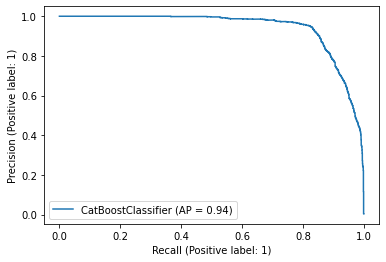

In [29]:
plot_precision_recall_curve(cad_2,X_test1,y_test1)

**precision et recall en fonction du seuil**

on recupère les probabilités que le modèle attribue à chaques transactions:

In [ ]:
y_scores=cross_val_predict(cad_2,X_train1,y_train1,cv=3,method="predict_proba")

on récupere les valeurs nécessaire pour tracer le graphe

In [31]:
precisions,recalls,seuils=precision_recall_curve(y_train1,y_scores[:,1])

Text(0.5, 0, 'seuil')

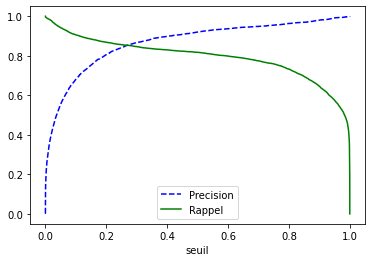

In [32]:
plt.figure()
plt.plot(seuils,precisions[:-1],'b--',label="Precision")
plt.plot(seuils,recalls[:-1],"g-",label="Rappel")
plt.legend()
plt.xlabel('seuil')

**changement du threshold**

pour atteindre 98% de recall on modifie le seuil en tâtonnant ( les résultats ne sont donc pas parfait, mais on vise une précision numérique du recall de l'odre du centième)

In [33]:
results=cad_2.predict_proba(X_test1)

In [79]:
seuil=0.023
result_réajusté=(results[:,1]>seuil)

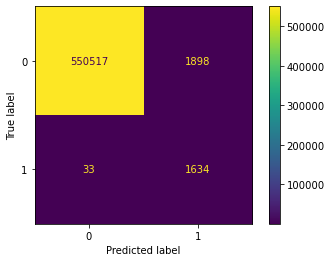

In [85]:
matrice1=confusion_matrix(y_test1,result_réajusté)
ConfusionMatrixDisplay(confusion_matrix=matrice1).plot()

In [80]:
métriques(result_réajusté,y_test1)

f1 score= 0.6285824196960955
precision= 0.4626274065685164
recall= 0.9802039592081584
roc_auc= 0.9883840682512015


CatBoost sans SMOTE nous donne donc une précision de 46% pour un recall de 98%

## 4) Compromis recall/précision (avec SMOTE_Tomek)

On va refaire la même chose  que ci-dessus mais avec un SMOTE Tomek équilibré (50% de fraudes, 50% de non-fraudes)

In [ ]:
test_model(cad,X_res_train3,X_test6,y_res_train3,y_test6)

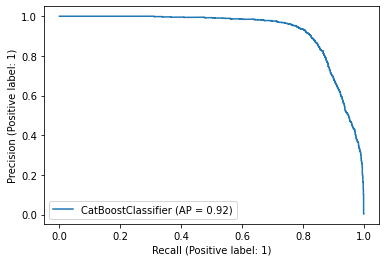

In [8]:
plot_precision_recall_curve(cad,X_test1,y_test1)

In [ ]:
y_scores_smote=cross_val_predict(cad,X_res_train3,y_res_train3,cv=3,method="predict_proba")

In [10]:
precisions_smote,recalls_smote,seuils_smote=precision_recall_curve(y_res_train3,y_scores_smote[:,1])

Text(0.5, 0, 'seuil')

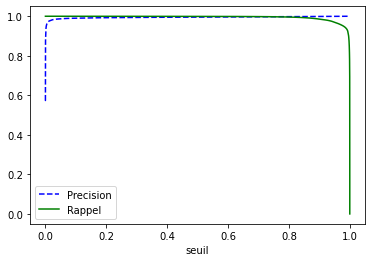

In [11]:
plt.figure()
plt.plot(seuils_smote,precisions_smote[:-1],'b--',label="Precision")
plt.plot(seuils_smote,recalls_smote[:-1],"g-",label="Rappel")
plt.legend()
plt.xlabel('seuil')

**(les graphiques montrant la précision et le recall en fonction du seuil sont faussés après SMOTE)**

In [12]:
results_smote=cad.predict_proba(X_test6)

In [92]:
seuil=0.34
result_réajusté_smote=(results_smote[:,1]>seuil)

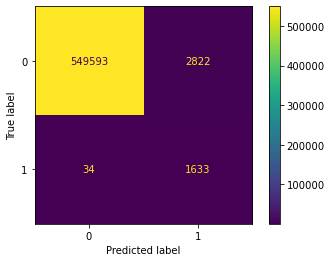

In [93]:
matrice=confusion_matrix(y_test6,result_réajusté_smote)
ConfusionMatrixDisplay(confusion_matrix=matrice).plot()

In [94]:
métriques(result_réajusté_smote,y_test6)

f1 score= 0.5334857889578569
precision= 0.3665544332210999
recall= 0.9796040791841631
roc_auc= 0.9872478004783718


La précision est inférieur avec un SMOTE_Tomek que sans pour un recall de 98%

## 5) GridSearchCV avec CATboost ( sans SMOTE)

Essayons d'améliorer notre modèle CATBoost sans SMOTE

In [101]:
params_catboost={'depth': [4, 7, 10],
          'learning_rate' : [0.03, 0.1, 0.15],
          'l2_leaf_reg': [1,4,9],
          'iterations': [300]}
grid_cat=GridSearchCV(cad,param_grid=params_catboost,cv=4,scoring=('recall','precision'),verbose=3,refit='recall')


In [ ]:
grid_cat.fit(X_train1,y_train1)

In [103]:
grid_cat.best_params_

{'depth': 7, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.15}

In [110]:
result=pd.DataFrame(grid_cat.cv_results_)
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_depth,param_iterations,param_l2_leaf_reg,param_learning_rate,params,split0_test_recall,...,mean_test_recall,std_test_recall,rank_test_recall,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,mean_test_precision,std_test_precision,rank_test_precision
0,103.421568,5.192515,0.559001,0.022262,4,300,1,0.03,"{'depth': 4, 'iterations': 300, 'l2_leaf_reg':...",0.629584,...,0.612131,0.010186,25,0.932971,0.936852,0.932521,0.928571,0.932729,0.002932,4
1,154.978100,28.389769,0.934206,0.250152,4,300,1,0.1,"{'depth': 4, 'iterations': 300, 'l2_leaf_reg':...",0.772616,...,0.758327,0.009317,17,0.919942,0.929385,0.917404,0.913947,0.920169,0.005730,24
2,173.717512,0.469517,1.103859,0.026384,4,300,1,0.15,"{'depth': 4, 'iterations': 300, 'l2_leaf_reg':...",0.794010,...,0.782465,0.009634,13,0.909664,0.920821,0.917798,0.911869,0.915038,0.004472,27
3,595.033856,729.383722,0.922080,0.232593,4,300,4,0.03,"{'depth': 4, 'iterations': 300, 'l2_leaf_reg':...",0.594743,...,0.597312,0.007789,26,0.945578,0.925676,0.932331,0.931067,0.933663,0.007319,2
4,167.315267,12.765084,1.128735,0.135099,4,300,4,0.1,"{'depth': 4, 'iterations': 300, 'l2_leaf_reg':...",0.753056,...,0.747787,0.006087,18,0.920777,0.929062,0.925134,0.912047,0.921755,0.006325,17
5,175.041687,1.090560,1.043527,0.011756,4,300,4,0.15,"{'depth': 4, 'iterations': 300, 'l2_leaf_reg':...",0.787286,...,0.778645,0.013130,14,0.916726,0.929429,0.922802,0.912331,0.920322,0.006440,22
6,525.718656,609.107442,0.904028,0.232852,4,300,9,0.03,"{'depth': 4, 'iterations': 300, 'l2_leaf_reg':...",0.595966,...,0.595632,0.004044,27,0.945684,0.932367,0.935762,0.929991,0.935951,0.005982,1
7,173.168296,2.371234,0.954670,0.132366,4,300,9,0.1,"{'depth': 4, 'iterations': 300, 'l2_leaf_reg':...",0.746333,...,0.741676,0.004943,19,0.913239,0.933904,0.921792,0.921391,0.922581,0.007374,13
8,174.701188,1.500680,0.872707,0.188280,4,300,9,0.15,"{'depth': 4, 'iterations': 300, 'l2_leaf_reg':...",0.778729,...,0.774062,0.006382,15,0.915888,0.932886,0.923358,0.913448,0.921395,0.007573,18
9,202.172025,0.361582,0.990050,0.141929,7,300,1,0.03,"{'depth': 7, 'iterations': 300, 'l2_leaf_reg':...",0.703545,...,0.707607,0.004555,22,0.929725,0.932956,0.929365,0.920319,0.928091,0.004700,7


Le modèle avec le meilleur recall est aussi 7ème en terme de précision, on va considerer que c'est le meilleur modèle de la grid

Entraînons ce modèle sur trainset complet

In [ ]:
cat_parametré=CatBoostClassifier(depth= 7, iterations= 300, l2_leaf_reg=1, learning_rate= 0.15)
test_model(cat_parametré,X_train1,X_test1,y_train1,y_test1)

In [13]:
predictions_cat_parametré=cat_parametré.predict(X_test1)
métriques(predictions_cat_parametré,y_test1)

f1 score= 0.8769475357710652
precision= 0.9330175913396481
recall= 0.8272345530893821


(quasiment pareil que sans changement des hyperparamètres)

Il sera necessaire d'aller plus moin pour optimiser ces hyperparamètres.
Cela dit, CATboost donne déja de bon résultats sans tuning, on devrait peut-être se concentrer sur XGBoost pour optimiser nos paramètres. 

# B) Optimisation de XGBoost

## 1) Compromis recall/précision ( sans SMOTE)

[18:07:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


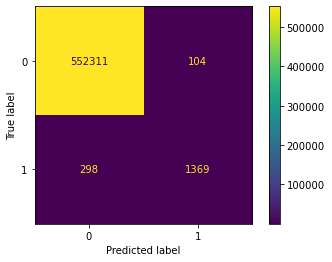

In [7]:
test_model(xgb,X_train1,X_test1,y_train1,y_test1)

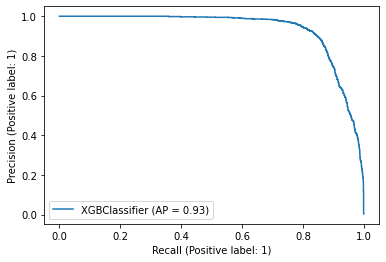

In [37]:
plot_precision_recall_curve(xgb,X_test1,y_test1)

In [8]:
y_scores_xgb=cross_val_predict(xgb,X_train1,y_train1,cv=3,method="predict_proba")

[18:30:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:42:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:50:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [9]:
precisions_xgb,recalls_xgb,seuils_xgb=precision_recall_curve(y_train1,y_scores_xgb[:,1])

Text(0.5, 0, 'seuil')

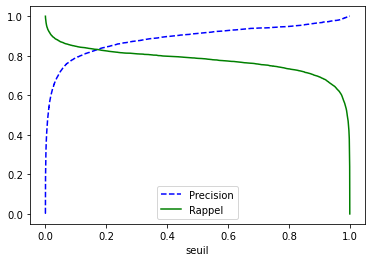

In [10]:
plt.figure()
plt.plot(seuils_xgb,precisions_xgb[:-1],'b--',label="Precision")
plt.plot(seuils_xgb,recalls_xgb[:-1],"g-",label="Rappel")
plt.legend()
plt.xlabel('seuil')

In [11]:
results_xgb=xgb.predict_proba(X_test1)

In [12]:
seuil=0.0025
result_réajusté_xgb=(results_xgb[:,1]>seuil)

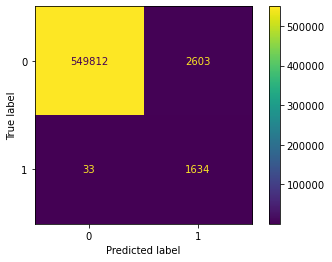

In [13]:
matrice_xgb=confusion_matrix(y_test1,result_réajusté_xgb)
ConfusionMatrixDisplay(confusion_matrix=matrice_xgb).plot()

In [43]:
métriques(result_réajusté_xgb,y_test1)

f1 score= 0.5535230352303523
precision= 0.38565022421524664
recall= 0.9802039592081584
roc_auc= 0.987745961031086


## 2) XGBoost avec SMOTE Tomek 

[18:59:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


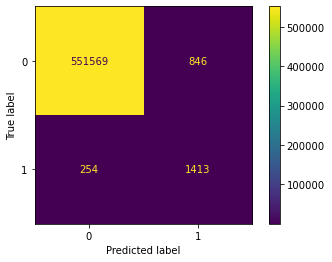

In [14]:
test_model(xgb_2,X_res_train3,X_test6,y_res_train3,y_test6)

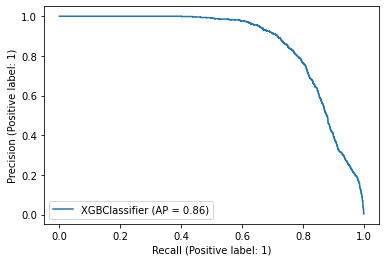

In [45]:
plot_precision_recall_curve(xgb_2,X_test6,y_test6)

In [46]:
y_scores_xgb_smote=cross_val_predict(xgb_2,X_res_train3,y_res_train3,cv=3,method="predict_proba")

[13:14:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:41:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:06:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [47]:
precisions_xgb_smote,recalls_xgb_smote,seuils_xgb_smote=precision_recall_curve(y_res_train3,y_scores_xgb_smote[:,1])

Text(0.5, 0, 'seuil')

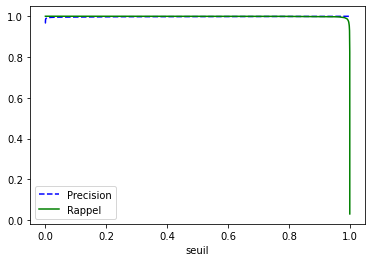

In [48]:
plt.figure()
plt.plot(seuils_xgb_smote,precisions_xgb_smote[:-1],'b--',label="Precision")
plt.plot(seuils_xgb_smote,recalls_xgb_smote[:-1],"g-",label="Rappel")
plt.legend()
plt.xlabel('seuil')

In [15]:
results_xgb_smote=xgb_2.predict_proba(X_test6)

In [16]:
seuil=0.00055
result_réajusté_xgb_smote=(results_xgb_smote[:,1]>seuil)

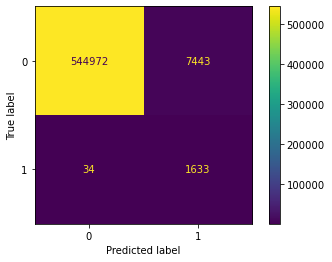

In [17]:
matrice_xgb_smote=confusion_matrix(y_test6,result_réajusté_xgb_smote)
ConfusionMatrixDisplay(confusion_matrix=matrice_xgb_smote).plot()

In [76]:
métriques(result_réajusté_xgb_smote,y_test6)

f1 score= 0.30401191473517636
precision= 0.17992507712648745
recall= 0.9796040791841631
roc_auc= 0.9830652565575876


## 3) GridSearchCV avec XGBoosting ( sans SMOTE)

Nous allons optimiser nos hyperparamètres XGBoost en limitant la taille de notre trainset (10%) pour éviter que cela mette trop de temps

**création d'un dataset réduit**

In [69]:
fraudes_1=fraudes.copy()
fraudes_réduit=fraudes_1.sample(frac=0.1, random_state=1)

In [78]:
def proprocess_reduit(df):
    df=retirer_transactions(df)  
    df=enlever_colonnes(df)
    df=encoder(df)
    df=scaler(df)

    X_red=df.drop('isFraud',axis=1)
    y_red=df['isFraud']
    
    X_train_red,X_test_red, y_train_red,y_test_red = train_test_split(X_red, y_red, test_size = 0.2, random_state = 15) 
    
    return X_train_red,X_test_red, y_train_red,y_test_red

In [79]:
X_train_red,X_test_red, y_train_red,y_test_red=proprocess_reduit(fraudes_réduit)

Au lieu de faire un gridSearch de tout les hyperparamètres que l'on souhait modifier, on va faire plusieurs grids où l'on ne cherchera à optimiser qu'un ou deux hyperparamètres.
On ajoutera au fur et à mesure nos meilleurs hyperparamètres aux grids suivantes

**optimisation de max_depth et min_child_weight**

In [ ]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,8,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=4,verbose=3)

gsearch1.fit(X_train_red,y_train_red) 

In [83]:
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 9, 'min_child_weight': 1}, 0.9962098199791154)

**Optimisation du paramètre gamma**

In [86]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5,verbose=3)
gsearch3.fit(X_train_red,y_train_red)
gsearch3.best_params_, gsearch3.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Users\matthias.picard\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:10:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'gamma': 0.4}, 0.9965296818177881)

**sub_sample et colsample_bytree**

In [88]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=9,
 min_child_weight=1, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4, cv=5)
gsearch4.fit(X_train_red,y_train_red)
gsearch4.best_params_, gsearch4.best_score_

C:\Users\matthias.picard\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:40:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'colsample_bytree': 0.8, 'subsample': 0.8}, 0.9966637365307445)

**reg_alpha**

In [89]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=9,
 min_child_weight=1, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4, cv=5)
gsearch6.fit(X_train_red,y_train_red)
gsearch6.best_params_, gsearch6.best_score_

C:\Users\matthias.picard\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'reg_alpha': 1}, 0.9967255466296685)

**reg alpha (plus précis)**

In [90]:
param_test7 = {
 'reg_alpha':[0.1, 0.2,0.5,0.8,1,1.2,1.5,2,3,5,10,20,50,100]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=9,
 min_child_weight=1, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4, cv=5)
gsearch7.fit(X_train_red,y_train_red)
gsearch7.best_params_, gsearch7.best_score_

C:\Users\matthias.picard\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:25:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'reg_alpha': 0.8}, 0.996877386749205)

**test du modèle**

[10:06:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


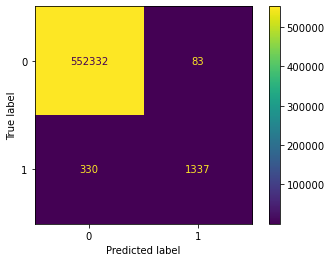

In [15]:
xgb_preprocessé=XGBClassifier( learning_rate =0.1, n_estimators=200, max_depth=9,
 min_child_weight=1, gamma=0.4, subsample=0.8, colsample_bytree=0.8,reg_alpha=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)

test_model(xgb_preprocessé,X_train1,X_test1,y_train1,y_test1)

In [16]:
predictions_xgb_preprocessé=xgb_preprocessé.predict(X_test1)
métriques(predictions_xgb_preprocessé,y_test1)

f1 score= 0.8662131519274376
precision= 0.9415492957746479
recall= 0.8020395920815837
roc_auc= 0.9009446713609768


En passant d'un XGBoost sans modification à un XGBoost optimisé, on voit que la précision passe de 0.929 à 0.942 et le recall de 0.821 à 0.802. Les changements semble assez minimes

[10:15:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:21:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:28:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:34:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

Text(0.5, 0, 'seuil')

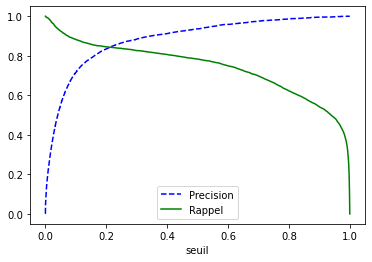

In [17]:
y_scores_xgb_preprocessé=cross_val_predict(xgb_preprocessé,X_train1,y_train1,cv=4,method="predict_proba")

precisions_xgb_preprocessé,recalls_xgb_preprocessé,seuils_xgb_preprocessé=precision_recall_curve(y_train1,y_scores_xgb_preprocessé[:,1])

plt.figure()
plt.plot(seuils_xgb_preprocessé,precisions_xgb_preprocessé[:-1],'b--',label="Precision")
plt.plot(seuils_xgb_preprocessé,recalls_xgb_preprocessé[:-1],"g-",label="Rappel")
plt.legend()
plt.xlabel('seuil')

In [18]:
results_xgb_preprocessé=xgb_preprocessé.predict_proba(X_test1)

In [34]:
seuil=0.02
result_réajusté_xgb_preprocessé=(results_xgb_preprocessé[:,1]>seuil)

In [ ]:
matrice_xgb_preprocessé=confusion_matrix(y_test1,result_réajusté_xgb_preprocessé)
ConfusionMatrixDisplay(confusion_matrix=matrice_xgb_preprocessé).plot()

In [35]:
métriques(result_réajusté_xgb_preprocessé,y_test1)

f1 score= 0.5179080824088748
precision= 0.3519276329959078
recall= 0.9802039592081584
roc_auc= 0.9873784836816297


pour un recall à 98%, la précision n'est que de 0.352, c'est moins que si l'on avait pas optimiser nos hyperparamètres...

# C) SECTION DE TEST 

## 1) modifier la pourcentage d'élement de la classe minoritaire apres le SMOTE

Si les résultats de nos modèles avec SMOTE sont inférieurs à ceux sans SMOTE, c'est peut-être parce que réequilibrer nos classe avec une proportion 50/50 n'est pas le meilleur choix pour des classes aussi désequilibrées que les nôtres.

On va donc modifier la proportion de fraudes apres le SMOTE. Elle sera ici de 5% ( au lieu de 50% donc).

In [89]:
def algo_smote_Tomek_r(X_train4, y_train4):
    sm = SMOTETomek (sampling_strategy=0.05)
    X_res_train, y_res_train = sm.fit_resample(X_train4, y_train4)
    return X_res_train, y_res_train 

In [86]:
fraudes_l=fraudes.copy()

In [90]:
def preprocess_SMOTE_limité(df):
    
    df=retirer_transactions(df)
    df=enlever_colonnes(df)
    df=encoder(df)
    df=scaler(df)
    
    
    X=df.drop('isFraud',axis=1)
    y=df['isFraud']
    
    X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size = 0.2, random_state = 30) 
    
    X_res_train, y_res_train = algo_smote_Tomek_r(X_train4, y_train4)
    
    return X_res_train, y_res_train,X_test4,y_test4

In [91]:
X_train_l, y_train_l,X_test_l,y_test_l=preprocess_SMOTE_limité(fraudes_l)

In [93]:
y_train_l.value_counts()

0    2208921
1     109629
Name: isFraud, dtype: int64

In [ ]:
test_model(cad_5,X_train_l,X_test_l,y_train_l,y_test_l)

In [98]:
predictions_cat_l=cad_5.predict(X_test_l)
métriques(predictions_cat_l,y_test_l)

f1 score= 0.8377081569291561
precision= 0.7910447761194029
recall= 0.8902219556088782
roc_auc= 0.9447561720877224


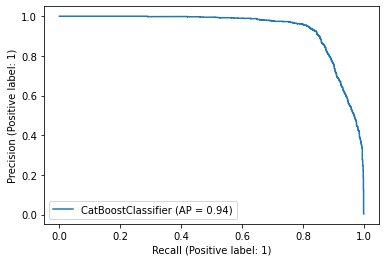

In [99]:
plot_precision_recall_curve(cad_5,X_test_l,y_test_l)

**tentative de creer un graphique des courbes de precision et de recall en fonction du seuil**

In [ ]:
y_scores_smote_l=cross_val_predict(cad_5,X_train_l,y_train_l,cv=3,method="predict_proba")

In [102]:
precisions_smote_l,recalls_smote_l,seuils_smote_l=precision_recall_curve(y_train_l,y_scores_smote_l[:,1])

Text(0.5, 0, 'seuil')

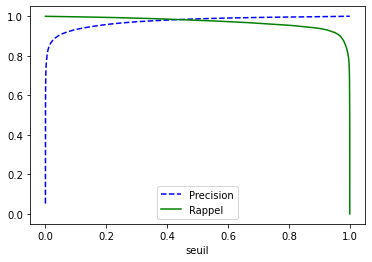

In [103]:
plt.figure()
plt.plot(seuils_smote_l,precisions_smote_l[:-1],'b--',label="Precision")
plt.plot(seuils_smote_l,recalls_smote_l[:-1],"g-",label="Rappel")
plt.legend()
plt.xlabel('seuil')

In [105]:
results_smote_l=cad_5.predict_proba(X_test_l)

In [109]:
seuil=0.1
result_réajusté_smote_l=(results_smote_l[:,1]>seuil)

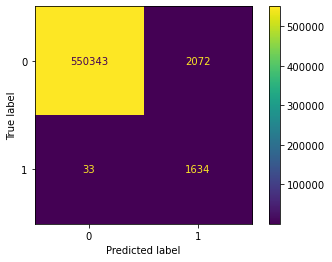

In [110]:
matrice_l=confusion_matrix(y_test_l,result_réajusté_smote_l)
ConfusionMatrixDisplay(confusion_matrix=matrice_l).plot()

In [111]:
métriques(result_réajusté_smote_l,y_test_l)

f1 score= 0.6082263167690304
precision= 0.4409066378845116
recall= 0.9802039592081584
roc_auc= 0.9882265779585772


précision de 0.441 --> mieux qu'avec une proportion à 50% mais toujours moins bien que sans SMOTE

## 2) retirer la variable oldbalanceOrg et comparer sans / avec SMOTE

In [6]:
def enlever_colonnes_old(df):
    heures=df.step %24
    df['heures']=heures
    df.drop(['nameOrig','newbalanceOrig','newbalanceDest','isFlaggedFraud','step','nameDest','oldbalanceOrg'],axis=1, inplace=True)
    return df

In [7]:
def scaler_old(df):
    scaler=RobustScaler()
    df_continue=scaler.fit_transform(df.loc[:,['amount','oldbalanceDest','heures']])
    df['amount']=df_continue[:,0]
    df['oldbalanceDest']=df_continue[:,1]
    df['heures']=df_continue[:,2]
    return df

In [8]:
fraudes_old_r=fraudes.copy()

In [9]:
def preprocess_rien_old(df):
    
    df=retirer_transactions(df)
    df=enlever_colonnes_old(df)
    df=encoder(df)
    df=scaler_old(df)
    
    
    X=df.drop('isFraud',axis=1)
    y=df['isFraud']
    
    X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size = 0.2, random_state = 30) 
    
   
    
    return X_train4, y_train4,X_test4,y_test4

In [10]:
fraudes_old_s=fraudes.copy()

In [11]:
def preprocess_SMOTE_old(df):
    
    df=retirer_transactions(df)
    df=enlever_colonnes_old(df)
    df=encoder(df)
    df=scaler_old(df)
    
    
    X=df.drop('isFraud',axis=1)
    y=df['isFraud']
    
    X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size = 0.2, random_state = 30) 
    
    X_res_train, y_res_train = algo_smote_Tomek(X_train4, y_train4)
    
    return X_res_train, y_res_train,X_test4,y_test4

In [12]:
X_train_rold, y_train_rold,X_test_rold,y_test_rold=preprocess_rien_old(fraudes_old_r)

In [16]:
X_train_sold, y_train_sold,X_test_sold,y_test_sold=preprocess_SMOTE_old(fraudes_old_s)

**recall precision**

In [ ]:
test_model(cad_3,X_train_rold,X_test_rold,y_train_rold,y_test_rold)

In [23]:
predictions_cad_rold=cad_3.predict(X_test_rold)
métriques(predictions_cad_rold,y_test_rold)

f1 score= 0.536225951698731
precision= 0.8440721649484536
recall= 0.3929214157168566
roc_auc= 0.6963511887468907


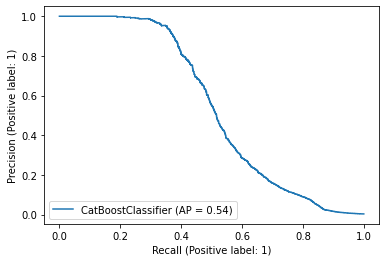

In [24]:
plot_precision_recall_curve(cad_3,X_test_rold,y_test_rold)

**tentative de creer un graphique des courbes de precision et de recall en fonction du seuil**

In [ ]:
y_scores_rold=cross_val_predict(cad_3,X_train_rold,y_train_rold,cv=3,method="predict_proba")

In [26]:
precisions_rold,recalls_rold,seuils_rold=precision_recall_curve(y_train_rold,y_scores_rold[:,1])

Text(0.5, 0, 'seuil')

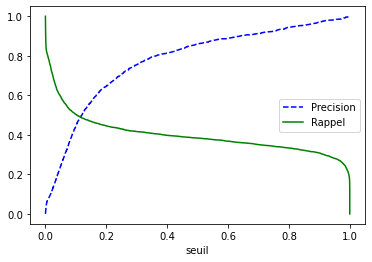

In [27]:
plt.figure()
plt.plot(seuils_rold,precisions_rold[:-1],'b--',label="Precision")
plt.plot(seuils_rold,recalls_rold[:-1],"g-",label="Rappel")
plt.legend()
plt.xlabel('seuil')

**changement du threshold**

In [28]:
results_rold=cad_3.predict_proba(X_test_rold)

In [77]:
seuil=0.0002
result_réajusté_rold=(results_rold[:,1]>seuil)

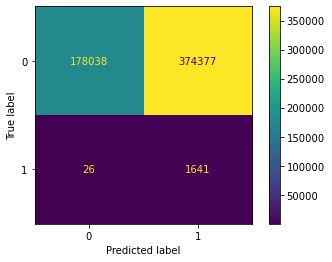

In [78]:
matrice_rold=confusion_matrix(y_test_rold,result_réajusté_rold)
ConfusionMatrixDisplay(confusion_matrix=matrice_rold).plot()

In [79]:
métriques(result_réajusté_rold,y_test_rold)

f1 score= 0.008689781166845387
precision= 0.00436415277992011
recall= 0.9844031193761248
roc_auc= 0.6533467132410977


**Compromis recall/précision (avec SMOTE_Tomek)**

In [ ]:
test_model(cad_4,X_train_sold,X_test_sold,y_train_sold,y_test_sold)

In [34]:
predictions_cat_sold=cad_4.predict(X_test_sold)
métriques(predictions_cat_sold,y_test_sold)

f1 score= 0.10047573739295908
precision= 0.05364109232769831
recall= 0.7918416316736653
roc_auc= 0.874842459890669


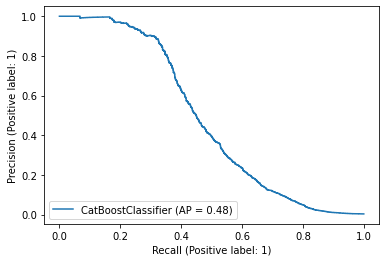

In [35]:
plot_precision_recall_curve(cad_4,X_test_sold,y_test_sold)

In [ ]:
y_scores_smote_sold=cross_val_predict(cad_4,X_train_sold,y_train_sold,cv=3,method="predict_proba")

In [39]:
precisions_smote_sold,recalls_smote_sold,seuils_smote_sold=precision_recall_curve(y_train_sold,y_scores_smote_sold[:,1])

Text(0.5, 0, 'seuil')

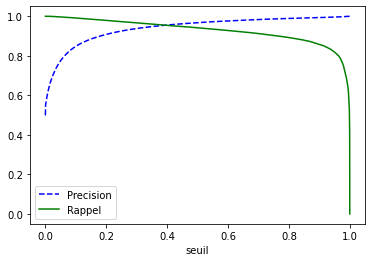

In [40]:
plt.figure()
plt.plot(seuils_smote_sold,precisions_smote_sold[:-1],'b--',label="Precision")
plt.plot(seuils_smote_sold,recalls_smote_sold[:-1],"g-",label="Rappel")
plt.legend()
plt.xlabel('seuil')

In [41]:
results_smote_sold=cad_4.predict_proba(X_test_sold)

In [57]:
seuil=0.5
result_réajusté_smote_sold=(results_smote_sold[:,1]>seuil)

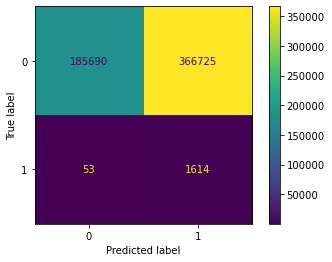

In [60]:
matrice_sold=confusion_matrix(y_test_sold,result_réajusté_smote_sold)
ConfusionMatrixDisplay(confusion_matrix=matrice_sold).plot()

In [61]:
métriques(result_réajusté_smote_sold,y_test_sold)

f1 score= 0.008724182851088901
precision= 0.004381833039672693
recall= 0.9682063587282543
roc_auc= 0.6521742853261303


## 3)  comment trouver des fraudes de manière quasi sûre

**mise en évidence d'un façon simple de detecter des fraudes**

On retrouve un pattern dans la grande majorité des fraudes du dataset. Nous allons montrer qu'en exploitant ce pattern, il est possible de créer un excellent modèle

In [24]:
fraudes_test=fraudes.copy()

In [ ]:
fraudes_test=retirer_transactions(fraudes_test)
fraudes_test['rapport']=fraudes_test['amount']/fraudes_test['oldbalanceOrg']

On peut montrer que la grande majorité des fraudes ont un rapport égal à 1.
Ce sont toutes les fraudes qui arrivent par paires

In [40]:
only_fraudes=fraudes_test[fraudes_test['isFraud']==1]

In [43]:
only_fraudes[only_fraudes['rapport']<1]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,rapport
4440,4,TRANSFER,10000000.00,C7162498,12930418.44,2930418.44,C945327594,0.00,0.00,1,0,0.773370
60853,9,TRANSFER,994453.20,C1121789613,1437370.87,442917.67,C254839817,194812.76,665743.67,1,0,0.691856
377151,17,CASH_OUT,42062.82,C897869440,340830.43,298767.61,C616721459,398931.35,678419.64,1,0,0.123413
481250,19,TRANSFER,10000000.00,C416779475,11861008.32,1861008.32,C380259496,0.00,0.00,1,0,0.843099
586311,33,TRANSFER,10000000.00,C1439740840,19887819.06,9887819.06,C875288652,0.00,0.00,1,0,0.502820
...,...,...,...,...,...,...,...,...,...,...,...,...
6362528,736,TRANSFER,10000000.00,C412961249,11314660.84,1314660.84,C253674970,0.00,0.00,1,0,0.883809
6362576,741,TRANSFER,10000000.00,C780743034,45674547.89,35674547.89,C491519946,0.00,0.00,1,0,0.218940
6362578,741,TRANSFER,10000000.00,C1111699947,35674547.89,25674547.89,C949015157,0.00,0.00,1,0,0.280312
6362580,741,TRANSFER,10000000.00,C88849251,25674547.89,15674547.89,C1939028448,0.00,0.00,1,0,0.389491


In [ ]:
only_fraudes[only_fraudes['rapport']>1]

A l'inverse, aucunes des transactions qui ne sont pas des fraudes ont un rapport égal à 1

In [46]:
not_fraudes=fraudes_test[fraudes_test['isFraud']==0]

In [50]:
not_fraudes[not_fraudes['rapport']==1]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,rapport


On peut donc facilement créer une fonction qui catégorise comme fraudes toutes les transactions dont le rapport est égal à 1.
On obtient le resultats suivant:

In [85]:
def modèle_triche(X):
    X=retirer_transactions(X)
    y=X['isFraud']
    X.drop('isFraud',inplace=True,axis=1)
    X['rapport']=X['amount']/X['oldbalanceOrg']
    resultats=X['rapport']==1
    resultats[resultats==True]=1
    resultats[resultats==False]=0
    métriques(resultats,y)
    #ConfusionMatrixDisplay(confusion_matrix(y,resultats)).plot()

modèle_triche(fraudes)

f1 score= 0.9879859528063581
precision= 1.0
recall= 0.976257153293559


on obtient une prédiction parfaite et un excellent recall

Il vaudrait donc mieux enlever toutes les transactions ayant un rapport=1, comme nous savons à coup sur que ce sont des fraudes

**Test du modèle CATboost sans les fraudes avec un rapport de 1**

In [91]:
lessfraudes=fraudes.copy()
lessfraudes=retirer_transactions(lessfraudes)
lessfraudes['rapport']=lessfraudes['amount']/lessfraudes['oldbalanceOrg']

lessfraudes=lessfraudes[lessfraudes['rapport']!=1]
lessfraudes['isFraud'].value_counts()

0    2762196
1        195
Name: isFraud, dtype: int64

In [ ]:
lessfraudes=enlever_colonnes(lessfraudes)
lessfraudes=encoder(lessfraudes)
lessfraudes=scaler(lessfraudes)
    
    
X_less=lessfraudes.drop('isFraud',axis=1)
y_less=lessfraudes['isFraud']
    

In [108]:
X_train_less, X_test_less, y_train_less, y_test_less = train_test_split(X_less, y_less, test_size = 0.2, random_state = 30) 

In [109]:
X_train_less

,amount,oldbalanceOrg,oldbalanceDest,rapport,heures,is_Cash_OUT
2354293,-0.210885,2.337490,-0.298836,1.715804,0.857143,0
5060395,-0.670628,0.320669,-0.060663,2.108868,0.285714,0
3546419,-0.165625,8.379818,0.772364,0.519054,0.571429,0
2621797,-0.621734,-0.009190,0.432034,inf,0.000000,0
4033490,88.461723,-0.009190,20.042123,inf,-0.714286,1
...,...,...,...,...,...,...
4751932,-0.452181,7.296026,4.435089,0.311868,0.714286,0
5566996,0.847969,0.145966,0.138552,75.394018,-1.000000,0
1303536,0.868312,-0.009190,0.275473,inf,0.000000,0
4748855,0.169187,-0.009190,0.176684,inf,0.714286,0


In [ ]:
test_model(cad,X_train_less, X_test_less, y_train_less, y_test_less)

In [112]:
predictions_cad_less=cad.predict(X_test_less)
métriques(predictions_cad_less,y_test_less)

f1 score= 0.875
precision= 0.9032258064516129
recall= 0.8484848484848485


Les resultats sont plutôt bons, mais on se confronte à un problème de manque de données ( seulement 36 fraudes dans le testset)
Dans ces conditions, il n'y a sans peut être pas d'intêret à continuer l'analyse

## 4) Autres tests pas aboutis

#### Learning curves 
(test)

In [99]:
N, train_score, val_score=learning_curve(arbre,X_res_train, y_res_train,train_sizes=np.linspace(0.1,1.0,15),cv=3)

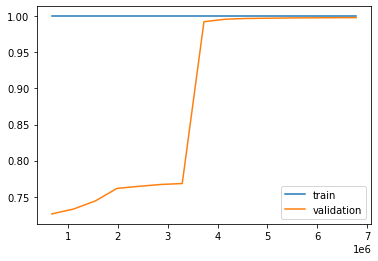

In [100]:
plt.figure()
plt.plot(N,train_score.mean(axis=1),label='train')
plt.plot(N,val_score.mean(axis=1),label='validation')
plt.legend()

#la courbe d'apprentissage augmente d'à peu pres 30 % entre 500 000 et 3,5 millions de lignes

##### creation d'un pipeline

In [36]:
dataset=fraudes.copy()


heures=dataset.step %24
dataset['heures']=heures

dataset.drop(['nameOrig','newbalanceOrig','newbalanceDest','isFlaggedFraud','step','nameDest'],axis=1, inplace=True)

X=dataset.drop('isFraud',axis=1)
y=dataset['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 30) 

column_transformer=make_column_transformer((OneHotEncoder(),['type']),(RobustScaler(),['amount','oldbalanceOrg','oldbalanceDest','heures']))


model_pipeline=make_pipeline(column_transformer, DecisionTreeClassifier())
model_pipeline.fit(X_train, y_train)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(), ['type']),
                                                 ('robustscaler',
                                                  RobustScaler(),
                                                  ['amount', 'oldbalanceOrg',
                                                   'oldbalanceDest',
                                                   'heures'])])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

**Visualiser un arbre de decision** (test)

In [64]:
dot_data=tree.export_graphviz(arbre,
                feature_names=['amount','oldbalanceOrg','oldbalanceDest','heures','is_Cash_OUT'],
                class_names='isFraud',
               rounded=True,
               filled=True)

In [ ]:
graph=graphviz.Source(dot_data)
graph

In [ ]:
plot_tree(arbre)

# VII) RECAP DE NOS RESULTATS

**recall toujours à 98%**


<img src='recall fixé à 98%.jpg'>